# CTH (cloud top height) computation of 2D VELOX BT (brightness temperature) fields

This is notebook is a showcase of the script to compute the 2D cloud top height fields (CTH_calculate_field.py). The basic idea is to fit the lapse rate and offset lineraly from the dropsonde temperature profiles and use this linear function to calculate the cloud top height from the cloud top temperature. Here, the process for calculating the 2D fields will be explained, for checking the computation of the lapse rate and offset see (CTH_coffs_notebook.ipynb). The outline of the notebook will be the following:
1. Imports, loading data and creating output dataset
2. Computing the (corrected) vza
3. Distance between VELOX and any field-pixel
4. Cloud mask comparison WALES - VELOX
5. Simulated BT
6. CTH Guessing algortihm 
7. Lapse rate and offset import 
8. Bringing it all togehter: calculate CTH


In [2]:
import numpy as np 
import datetime 
import os 
import glob
import xarray as xr
import eurec4a
from intake import open_catalog
from CTH_helper import *
from scipy.stats import linregress
import matplotlib.dates as mdates
from numba import njit

colors={
    "WALES": "darkgreen",
    "HAMP Radar": "navy",
    "specMACS": "darkred",
    "HAMP Radiometer": "palevioletred",
    "KT19": "coral",
    "VELOX": "darkblue",
       }

In [42]:
f = 'Flight_20200128a'
fnum = str(f[7:-1])
Y, M, D = int(fnum[0:4]), int(fnum[4:6]), int(fnum[6:])
f_format = f'HALO-{fnum[6:]}{fnum[4:6]}'

path = '/projekt_agmwend/data/EUREC4A/06_Flights/'+f+'/VELOX/VELOX_327kveL/'
tb_name = 'EUREC4A_HALO_VELOX_BT_Filter_01_'+str(f[7:-1])+'_v0.4.nc'
cm_name = 'EUREC4A_HALO_VELOX_cloudmask_'+str(f[7:-1])+'_v4.1.nc'
params_name = glob.glob(os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights',f,'BAHAMAS')+'/*.nc')[0]
wl_name = glob.glob(os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights', f, 'WALES','*V2.1.nc'))[0]

#name of the output file to be generated

cth_name = 'EUREC4A_HALO_VELOX_CTH_'+f+'_v0.4.nc'
xrcm  = xr.open_dataset(path+cm_name)
xrtb = xr.open_dataset(path+tb_name)
xrwl = xr.open_dataset(wl_name)
xrparams = xr.open_dataset(params_name)

all_flight_segments = eurec4a.get_flight_segments()
circles = [item for item in all_flight_segments['HALO'][f'HALO-{str(f[11:-1])}']['segments'] if 'circle' in item['name'] and len(item['dropsondes']['GOOD']) > 5 ]
# Get the ranges of indices for xrtb in the circle, to later select only those datapoints which were obtained while flying in a circle
ranges = [np.arange(np.where(xrtb.BT_Center==xrtb.BT_Center.sel(time=circles[i]['start'], method='nearest'))[0], np.where(xrtb.BT_Center==xrtb.BT_Center.sel(time=circles[i]['end'], method='nearest'))[0]) for i in range(len(circles))]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
np.where(xrtb.time==xrtb.time.sel(time=circles[0]['end'], method='nearest'))

(array([2738]),)

In [49]:
np.where(xrtb.BT_Center==xrtb.BT_Center.sel(time=circles[0]['end'], method='nearest'))[0]
#ranges = [np.arange(np.where(xrtb.BT_Center==xrtb.BT_Center.sel(time=circles[i]['start'], method='nearest'))[0], np.where(xrtb.BT_Center==xrtb.BT_Center.sel(time=circles[i]['end'], method='nearest'))[0]) for i in range(len(circles))]


array([ 550, 2738])

In [3]:
output_dataset = xr.Dataset(
    data_vars = dict(
        vza = xrtb['vza'],
        vaa = xrtb['vaa'],
        cloud_mask = xrcm['cloud_mask']
    ),
    coords = dict(
        time = xrtb['time']
    ),
    attrs = dict(
        title = 'Two-dimensional cloud-top height with 1 Hz temporal resolution derived from VELOX brightness temperature during the EUREC4A field campaign.',
        version = 'Version v0.31 from 2022-02-06',
        comment_1 = 'cloud-height is derived from combination of 7.70 -12.00 micrometer VELOX brightness temperature with dropsondes and cross-calibrated with WALES cloud-top height. Applied cloud_mask is provided with treshold cloud_mask == 2.' ,
        variable = 'cth, cloud_mask',
        author = 'Michael Schäfer, André Ehrlich, Anna Luebke, Jakob Thoböll, Kevin Wolf, Joshua Müller, Manfred Wendisch',
        history = '2022-06-21 : updated dataset attributes, 2022-08-17 : improved cross calibration with wales lidar',
        created_on = '2022-02-06'
    )
)

In [4]:
xrHALO = xr.Dataset(
    data_vars=dict(
        lat=(["time"], xrparams['IRS_LAT'].values),
        lon=(["time"], xrparams['IRS_LON'].values),
        alt=(["time"], xrparams['IRS_ALT'].values),
        roll=(["time"], xrparams['IRS_PHI'].values),
        pitch=(["time"], xrparams['IRS_THE'].values),
        hdg=(["time"], xrparams['IRS_HDG'].values),
    ),
    coords=dict(
        time=xrparams['TIME'].values,),)

## Taking a look...

After importing moduls and handling the data import with xarray, we can take a first look at the data. This is a short repetition of cth_coffs.ipynb. The plot shows the correlation between VELOX' central 10x10 nadir pixel mean brightness temperature and WALES LIDAR cloud top height. 

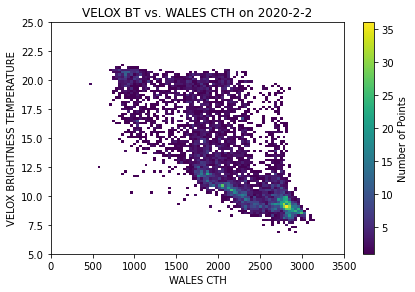

In [5]:
#computing nadir cloud mask
CM_center = xrcm.cloud_mask.isel(y=slice(251,261), x=slice(315, 325)).mean(dim = {'x', 'y'})
plt.hist2d(xrwl['cloud_top'].interp_like(xrtb.BT_Center[CM_center > 0]
), xrtb.BT_Center[CM_center > 0]
, bins= 100, range=((0,3500), (5,25)), cmin=1, cmap='viridis', density=False)
cb = plt.colorbar(label ='Number of Points')
plt.xlabel('WALES CTH')
plt.ylabel('VELOX BRIGHTNESS TEMPERATURE')
plt.tight_layout()
plt.title('VELOX BT vs. WALES CTH on '+'-'.join([str(Y),str(M),str(D)]))

#plt.savefig(f"EUREC4A_HALO_VELOX_BT_10x10_Pixel_WALES_vs_VELOX_BRITGHTNESS_TEMPERATURE_{str(f[7:-1])}.png", dpi = 600)
plt.show()

## Computing VZA 
Computing the viewing azimuth angle (vza), as the current vza in the brightness temperature file is independent from pitch and roll. The compute_vza function takes as input pitch and roll and computes the (impilict time-dependent vza). The plot below shows the difference between the current vza and the vza computed by the function below. The differences should equal to zero - though they reach up to 0.4 degree. 


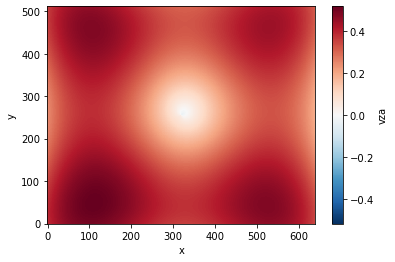

In [6]:
def compute_vza(roll, pitch):

    alpha, beta, pitch, roll = np.radians(35), np.radians(28), np.radians(pitch), np.radians(roll)
    alpha_rolled = np.abs(np.linspace(-alpha/2 + roll, alpha/2 + roll, 640)) 
    beta_pitched = np.abs(np.linspace(-beta/2 + pitch, beta/2 + pitch, 512))
    X, Y = np.meshgrid(beta_pitched, alpha_rolled, copy=False)
    
    return np.degrees(np.arctan(((np.tan(X))**2 + (np.tan(Y))**2)**0.5))
    
(xrtb['vza'] - compute_vza(0, 0)).transpose('y', 'x').plot()
plt.show()

## Distance between VELOX and any Pixel in the FOV

After calculating the pitch/roll-dependent vza the distance to any pixel in the FOV can be calculated. This is needed later on for the atmospheric absorbtion to avoid systematic errors at the edges. Below the distance matrix for each pixel is calculated. Additionally a comparison between no roll and a slight roll (2.2 degree), which is realistic for flying the circle, ist performed. It shows that the difference can reach more than 100m. 

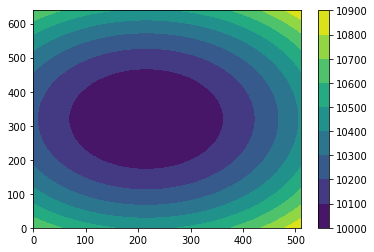

The difference of between including roll and not including roll can reach up to 108m


In [7]:
def dist3D(vza, height):
    vza = np.radians(vza)
    return (height**2 * (np.tan(vza)**2 + 1))**0.5

dist_matrix = np.array(dist3D(compute_vza(0, 2.2), 10000), dtype=np.int64)
dist_matrix_no_roll = np.array(dist3D(compute_vza(0, 0), 10000), dtype=np.int64)
plt.contourf(dist_matrix, levels = (10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900))
plt.colorbar()
plt.show()

print(f'The difference of between including roll and not including roll can reach up to {(dist_matrix - dist_matrix_no_roll).max()}m')

## Cloud Masks 
A short comparison between VELOX cloud mask and WALES LIDAR cloud mask. In the case of VELOX the spatial averaged 10x10 Nadir Pixels are used and transformed to a binary 
Over the 6 circles performed during the day, both masks match for most of time though some circles agree better than others (eg. 2 vs. 3). The masks are averaged over 10 seconds and interpolated to the 1 second resolution of VELOX.  

In [8]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

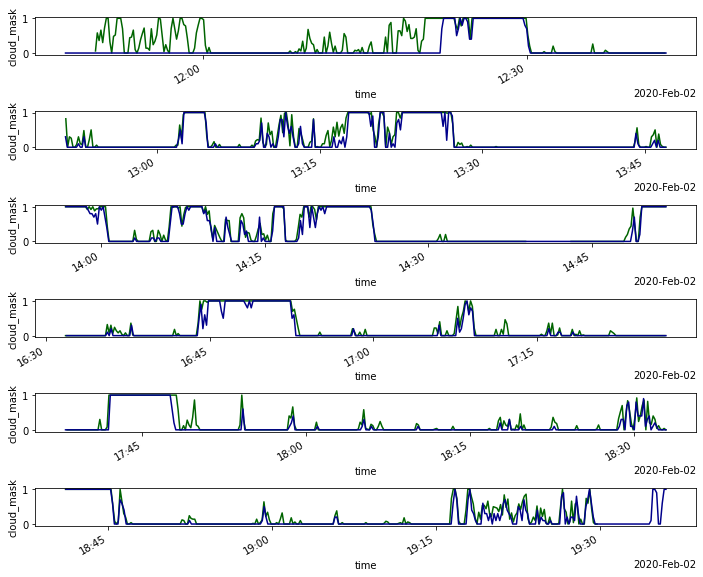

In [9]:
min_cloud_binary_mask = (xrwl.cloud_mask == 2).where(xrwl.cloud_mask.notnull())
max_cloud_binary_mask = (xrwl.cloud_mask > 0).where(xrwl.cloud_mask.notnull())
WALES_cloud_mask = max_cloud_binary_mask.coarsen(time=50, boundary='trim').mean()
VELOX_cloud_mask_max = xrcm['CF_max'].coarsen(time=10, boundary='trim').mean()
VELOX_cloud_mask_center = (CM_center > 1).where(CM_center.notnull()).coarsen(time=10, boundary='trim').mean()

fig, axs = plt.subplots(len(circles), 1, figsize=(10,8))
for ax, circle in zip(axs, circles):
    locator = mdates.AutoDateLocator(minticks=5, maxticks=5)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    WALES_cloud_mask.sel(time=slice(circle['start'], circle['end'])).plot(color = 'darkgreen', ax=ax)
    VELOX_cloud_mask_center.sel(time=slice(circle['start'], circle['end'])).plot(color = 'darkblue', ax=ax)
plt.tight_layout()

## Simulated BT

Loading the simulated brightness temperatures for different flying altitudes. These are the cloud free brightness temperatures VELOX should measure if flying at this altitude. Therefore the atmospheric absorbtion can be calculated. Let the simulated brightness temperature at 10km (flying altitude) and at cloud top be $T_{s, HALO}$ and $T_{s, CTH}$ respectivly. Then the atmospheric absorbtion $T_{abs}$ can be calculated as following:  
  $T_{abs} = T_{s, CTH} - T_{s, HALO}$  
Therefore a guess for the cloud top height is needed to estimate the atmospheric absorbtion. To emphasize the importance of this guess, the average atmospheric absorbtion for a cloud at 2800m and a cloud at 800m ist calculated. With a difference over 2.3K this translates into a CTH difference of over 300m (for a lapse rate of 140m/K). 

In [10]:
sims = load_sims(f)
sim_datetime = [datetime.datetime(Y,M,D) + datetime.timedelta(seconds=sims[0,i,0]) for i in range(len(sims[0,:,0]))]
sim_np64 = np.array(sim_datetime, dtype=np.datetime64)
height = np.array([250, 500, 750, 1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])

xr_sim = xr.Dataset(
    data_vars=dict(
        dT=(["height", "time"], sims[:,:,1]),
    ),
    coords=dict(
        time=sim_np64,
        height=height,
    ),
    attrs=dict(description=f"VELOX{fnum} 10x10 NADIR PIXEL MEAN BT"))

sim_interp = xr_sim.interp(height=np.arange(1,13001),
    method="linear",
    kwargs={"fill_value": "extrapolate"},).interp_like(xrtb)

T_abs_2800 = (sim_interp.sel(height=2800) - sim_interp.sel(height=10030)).dT.mean()
T_abs_800  = (sim_interp.sel(height=800) - sim_interp.sel(height=10030)).dT.mean()
print(f'Atmospheric absorbtion for a cloud at 2800m and 800m is on average {T_abs_2800.values:.2f}K and {T_abs_800.values:.2f}K respectivly.')

Atmospheric absorbtion for a cloud at 2800m and 800m is on average 1.67K and 3.97K respectivly.


## Guessing the CTH
For guessing the CTH, a statistical approach is used. The distribution of the clouded nadir brightness temperature (BT) by VELOX and the corresponding CTH measured by WALES LIDAR (as shown in the plot above) are known and it is assumed that there is a linear relationship (with negative slope) between them. Therefore a clouded pixel with BT in i-th percentile will corrsepond to a CTH in the (100-i)-th percentile. 

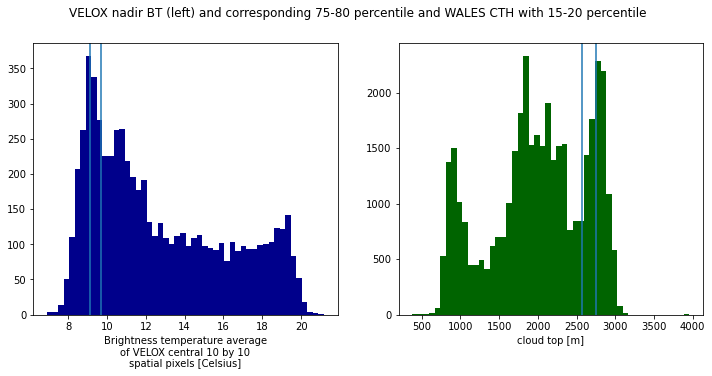

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

xrtb['BT_Center'][CM_center > 1].plot.hist(bins=50, ax=ax[0], color=colors['VELOX'])
ax[0].axvline(xrtb['BT_Center'][CM_center > 1].quantile(0.15))
ax[0].axvline(xrtb['BT_Center'][CM_center > 1].quantile(0.25))
xrwl['cloud_top'].plot.hist(bins=50, ax=ax[1], color=colors['WALES'])
ax[1].axvline(xrwl['cloud_top'].quantile(0.85))
ax[1].axvline(xrwl['cloud_top'].quantile(0.75))
plt.suptitle('VELOX nadir BT (left) and corresponding 75-80 percentile and WALES CTH with 15-20 percentile')
plt.show()

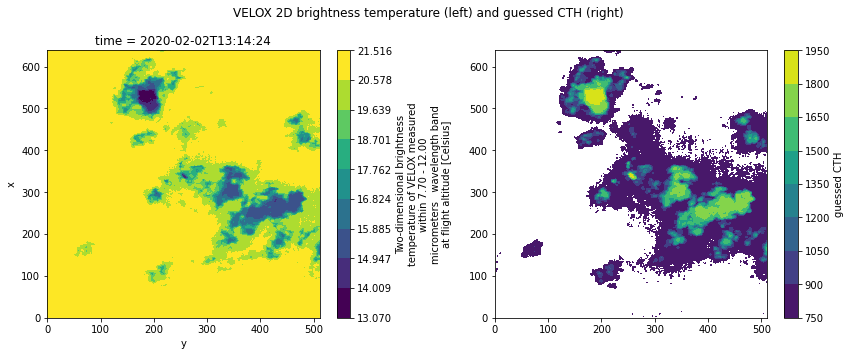

In [12]:
def precalc_percentiles(cth):

    percentiles = np.array([cth.quantile(q) for q in np.linspace(0,1,102)])
    percentiles_range = [np.where((cth >= percentiles[i-1]) & (cth <= percentiles[i+1]))[0] for i in range(1,101)]

    return np.array([cth[wales_index].mean() for wales_index in percentiles_range])


percentiles_mean = precalc_percentiles(xrwl['cloud_top'])

@njit

def guess_cth(bt_array, cm_array ,bt_center, percentiles_mean=percentiles_mean[::-1]):

    cth_array = np.zeros(bt_array.shape) * np.nan

    for i in range(bt_array.shape[0]):
        for j in range(bt_array.shape[1]):
            if cm_array[i,j] > 0:
                q = int(np.count_nonzero(bt_array[i,j] > bt_center) / len(bt_center) * 100)
                cth_array[i,j] = percentiles_mean[q]


    return cth_array


cth = guess_cth(xrtb.BT_2D.isel(time=5783).values, xrcm['cloud_mask'].isel(time=5783).transpose('x','y').values, xrtb.BT_Center[CM_center > 1].values)

#%timeit guess_cth(xrtb.BT_2D.isel(time=12700).values, xrcm['cloud_mask'].isel(time=12700).transpose('x','y').values, xrtb['BT_Center'].values)

fig, ax = plt.subplots(1,2, figsize=(12,5))
im = ax[1].contourf(cth)
fig.colorbar(im, label= 'guessed CTH')
im2 = xrtb.BT_2D.isel(time=5783).plot.contourf(ax=ax[0], levels=np.linspace(xrtb.BT_2D.isel(time=5783).min(), xrtb.BT_2D.isel(time=5783).max(), 10))
plt.suptitle('VELOX 2D brightness temperature (left) and guessed CTH (right)')
plt.tight_layout()

## Lapse rate and offset import
The lapse rate (fitted from the slope of the temperature profile) and the offset (cross-calibrated with the measurement from WALES Lidar) are calculated in CTH_calculate_coffs.py. They have a high timely resolution and it seems reasonable to average them over a certain time interval (here: 10 min). Though as the picked interval is arbitrary, the influence of the length of averaging should be estimated.  

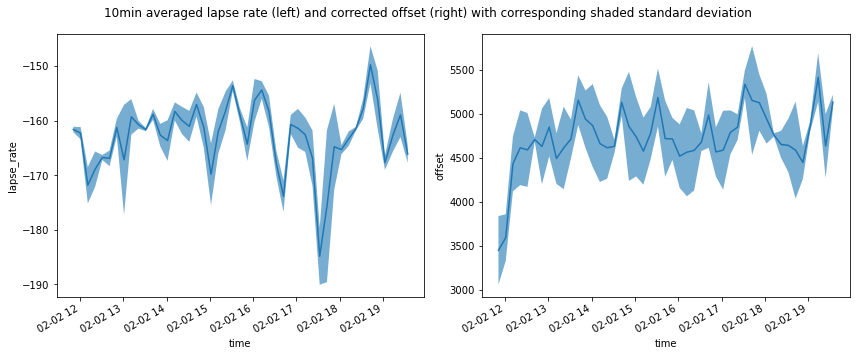

In [13]:
### Importing the lapse rate and offset for the relationship CTH(T) = lapse rate * T + offset
### These coeffients were calculated in CTH_calculate_coffs.py
import warnings
warnings.filterwarnings('ignore')

xrcoff = xr.open_dataset(f'/home/jomueller/{fnum}_coffs.nc', engine='netcdf4')
params_interp = xrHALO.interp_like(xrtb)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

averaged_lapse_rate = xrcoff.lapse_rate.coarsen(time=10000, boundary='trim')
averaged_lapse_rate.mean().plot(ax=ax1)
ax1.fill_between(averaged_lapse_rate.mean().time.values, averaged_lapse_rate.mean() - averaged_lapse_rate.std(), averaged_lapse_rate.mean() + averaged_lapse_rate.std(), alpha=0.6,)

averaged_offset = xrcoff.offset.coarsen(time=10000, boundary='trim')
averaged_offset.mean().plot(ax=ax2)
ax2.fill_between(averaged_offset.mean().time.values, averaged_offset.mean() - averaged_offset.std(), averaged_offset.mean() + averaged_offset.std(), alpha=0.6)
plt.suptitle('10min averaged lapse rate (left) and corrected offset (right) with corresponding shaded standard deviation')
plt.tight_layout()


# Putting it all together...

In the following cell, all the functions will be put together to determine the CTH of an examplary frame. The computed CTHs have their maximum at about 900m - which seems realistic for this scene.

lapse rate = -159.79079595456835 
 offset = 4533.000333264323


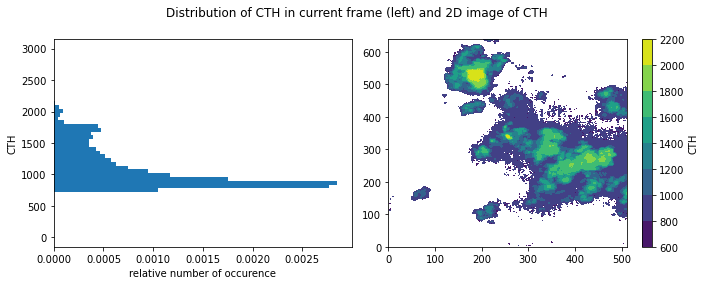

In [14]:
i = 5783

alt, roll, pitch = params_interp['alt'].isel(time=i), params_interp['roll'].isel(time=i), params_interp['pitch'].isel(time=i)
distance = np.array(dist3D(compute_vza(pitch, roll), alt.values), dtype=np.int64)
index = np.where((xrcm['cloud_mask'].transpose('x', 'y', 'time')[:,:,i] > 0))
cth_array = np.zeros(xrtb['BT_2D'].shape) * np.nan
BT_sim = sim_interp['dT'].isel(time=i)
BT_timestep = xrtb['BT_2D'].isel(time=i)

lapse_rate = averaged_lapse_rate.mean().interp_like(xrtb).values[i]
offset = averaged_offset.mean().interp_like(xrtb).values[i]

print(f'lapse rate = {lapse_rate} \n offset = {offset}')

cth_guess = np.array(guess_cth(BT_timestep.values, xrcm['cloud_mask'].transpose('x', 'y', 'time')[:,:,i].values ,xrtb['BT_Center'][CM_center >0].values), dtype=np.int32)

BT_cloudy = BT_timestep.values[index]
# xarray indexing is weird ... and slow -> change to numpy indexing 

atmos_absorbtion_cloud_top = BT_sim.sel(height=cth_guess[index]).values
atmos_absorbtion_airplane  = BT_sim.sel(height=distance[index]).values

cth_array[i][index] =  lapse_rate * ( (atmos_absorbtion_cloud_top - atmos_absorbtion_airplane) + BT_cloudy ) + offset

fig, axs = plt.subplots(1,2, figsize=(10,4))
im = axs[1].contourf(cth_array[i,:,:])
fig.colorbar(im, label='CTH')
axs[0].set_xlabel('relative number of occurence')
axs[0].set_ylabel('CTH')
axs[0].hist(cth_array[i][index].flatten(), range=(1,3000), bins= 50, orientation='horizontal', density=1)
plt.suptitle('Distribution of CTH in current frame (left) and 2D image of CTH')
plt.tight_layout()
plt.show()